# Load Libraries

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchsummary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Set Hyper Parameters

In [3]:
hyper_parameters = {
    "SEED":1990,
    "notebookName":"ComplexModel2",
    "nepochs":10000,
    "batch_size":256,
    "learning_rate":0.001,
    "window_size":128,
    "max_patience_count":1000
}

In [4]:
torch.manual_seed(hyper_parameters["SEED"])

In [5]:
f"./models/{hyper_parameters['notebookName']}"

'./models/ComplexModel2'

In [6]:

PATH = Path(f"./models/{hyper_parameters['notebookName']}")
if os.path.isdir(PATH):
    dir_list = os.listdir(PATH)
    num_files = 0
    while True:
        if os.path.isfile(str(PATH / f"{num_files}")):
            print(num_files)
            num_files += 1
        else:
            break
else:
    os.mkdir(PATH)
    num_files = 0
num_files = 2

# Set Path

In [7]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")

# Help Functions

# Load Data

In [8]:
df_train_default = pd.read_pickle(str(data_dir / "gsdc_extract_train.pkl.gzip"))

In [9]:
df_test = pd.read_pickle(str(data_dir / "gsdc_extract_test.pkl.gzip"))

In [10]:
for col in df_train_default.columns:
    print(col)

collectionName
phoneName
millisSinceGpsEpoch
latDeg
lngDeg
heightAboveWgs84EllipsoidM
phone
timeSinceFirstFixSeconds
hDop
vDop
speedMps
courseDegree
t_latDeg
t_lngDeg
t_heightAboveWgs84EllipsoidM
constellationType
svid
signalType
receivedSvTimeInGpsNanos
xSatPosM
ySatPosM
zSatPosM
xSatVelMps
ySatVelMps
zSatVelMps
satClkBiasM
satClkDriftMps
rawPrM
rawPrUncM
isrbM
ionoDelayM
tropoDelayM
utcTimeMillis
TimeNanos
LeapSecond
FullBiasNanos
BiasNanos
BiasUncertaintyNanos
DriftNanosPerSecond
DriftUncertaintyNanosPerSecond
HardwareClockDiscontinuityCount
Svid
TimeOffsetNanos
State
ReceivedSvTimeNanos
ReceivedSvTimeUncertaintyNanos
Cn0DbHz
PseudorangeRateMetersPerSecond
PseudorangeRateUncertaintyMetersPerSecond
AccumulatedDeltaRangeState
AccumulatedDeltaRangeMeters
AccumulatedDeltaRangeUncertaintyMeters
CarrierFrequencyHz
MultipathIndicator
ConstellationType
AgcDb
BasebandCn0DbHz
FullInterSignalBiasNanos
FullInterSignalBiasUncertaintyNanos
SatelliteInterSignalBiasNanos
SatelliteInterSignalBiasUnc

# Dataloader

In [11]:
df_train_default['phone'].value_counts()

2021-04-22-US-SJC-1_Pixel4             2890
2021-04-22-US-SJC-1_SamsungS20Ultra    2826
2020-09-04-US-SF-2_Mi8                 2500
2021-04-29-US-SJC-2_SamsungS20Ultra    2370
2020-09-04-US-SF-2_Pixel4              2349
                                       ... 
2021-01-05-US-SVL-2_Pixel4XL           1193
2020-06-05-US-MTV-1_Pixel4XLModded     1123
2021-04-26-US-SVL-1_Mi8                1036
2021-04-26-US-SVL-1_Pixel5             1034
2020-05-14-US-MTV-2_Pixel4XLModded      577
Name: phone, Length: 73, dtype: int64

In [12]:
def CustomTrainValidSplit(df:pd.DataFrame, valid_size):
    phones = df['phone'].unique()
    
    valid_num = int(len(phones) * valid_size)
    train_num = len(phones) - valid_num
    
    indexes = np.array(range(len(phones)))
    indexes = np.random.choice(indexes, len(indexes))
    
    df_train = []
    for phone in phones[indexes[:train_num]]:
        df_train.append(df[df['phone'] == phone])
    df_train = pd.concat(df_train)
    
    df_valid = []
    for phone in phones[indexes[train_num:-1]]:
        df_valid.append(df[df['phone'] == phone])
    df_valid = pd.concat(df_valid)
    
    return df_train.reset_index().drop(columns = 'index'), df_valid.reset_index().drop(columns = 'index')
    
df_train, df_valid = CustomTrainValidSplit(df_train_default, valid_size = 0.1)
print(df_train.shape, df_valid.shape)
    

(118139, 148) (11209, 148)


In [13]:
df_train

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,timeSinceFirstFixSeconds,hDop,vDop,...,GPS_L1,GPS_L5,GAL_E1,GAL_E5A,GLO_G1,BDS_B1I,BDS_B1C,BDS_B2A,QZS_J1,QZS_J5
0,2021-01-05-US-SVL-1,Pixel5,1293916337690,37.379422,-122.072131,-7.15,2021-01-05-US-SVL-1_Pixel5,215.69,0.9,0.0,...,0,0,0,0,1,0,0,0,0,0
1,2021-01-05-US-SVL-1,Pixel5,1293916338671,37.379531,-122.072081,7.25,2021-01-05-US-SVL-1_Pixel5,216.67,0.9,0.0,...,1,0,0,0,0,0,0,0,0,0
2,2021-01-05-US-SVL-1,Pixel5,1293916339660,37.379437,-122.072078,-9.97,2021-01-05-US-SVL-1_Pixel5,217.66,0.9,0.0,...,1,0,0,0,0,0,0,0,0,0
3,2021-01-05-US-SVL-1,Pixel5,1293916340672,37.379435,-122.072134,1.38,2021-01-05-US-SVL-1_Pixel5,218.67,0.9,0.0,...,1,0,0,0,0,0,0,0,0,0
4,2021-01-05-US-SVL-1,Pixel5,1293916341663,37.379429,-122.072103,-3.53,2021-01-05-US-SVL-1_Pixel5,219.66,0.9,0.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118134,2021-01-05-US-SVL-1,Mi8,1293917677000,37.379366,-122.072157,11.88,2021-01-05-US-SVL-1_Mi8,1555.00,0.8,0.0,...,0,0,1,0,0,0,0,0,0,0
118135,2021-01-05-US-SVL-1,Mi8,1293917678000,37.379371,-122.072157,9.07,2021-01-05-US-SVL-1_Mi8,1556.00,0.8,0.0,...,0,0,0,0,1,0,0,0,0,0
118136,2021-01-05-US-SVL-1,Mi8,1293917679000,37.379378,-122.072148,10.35,2021-01-05-US-SVL-1_Mi8,1557.00,0.8,0.0,...,1,0,0,0,0,0,0,0,0,0
118137,2021-01-05-US-SVL-1,Mi8,1293917680000,37.379365,-122.072158,9.80,2021-01-05-US-SVL-1_Mi8,1558.00,0.8,0.0,...,0,0,1,0,0,0,0,0,0,0


In [14]:
def GetWindowsRight(idx, window_size):
    index = np.array([])
    if idx < window_size:
        index = np.concatenate([np.zeros(window_size - idx-1), np.array(range(idx+1))])
        pass
    else:
        index = np.array(range(idx-window_size+1, idx+1))
    return index.astype(int)

def GetWindowsMid(idx, window_size, max_idx):
    left_index = np.array([])
    right_index = np.array([])
    
    left_size = int(round(window_size * 0.5))
    right_size = window_size - left_size
    if idx - left_size< 0:
        left_index = np.concatenate([np.zeros(left_size - idx-1), np.array(range(idx+1))])
    else:
        left_index = np.array(range(idx-left_size, idx+1))
    
    if idx + right_size> max_idx:
        right_index = np.concatenate([np.array(range(idx+1, max_idx+1)), (max_idx)*np.ones(right_size - (max_idx - idx) + 1)])
    else:
        right_index = np.array(range(idx+1, idx + right_size))
    
    index = np.concatenate([left_index, right_index])
    
    return index.astype(int)

def GetWindowsWithRatio(idx, max_idx, window_size, window_ratio = 1.):
    left_index = np.array([])
    right_index = np.array([])
    
    left_size = int(round(window_size * window_ratio))
    right_size = window_size - left_size
    if idx - left_size< 0:
        left_index = np.concatenate([np.zeros(left_size - idx-1), np.array(range(idx+1))])
    else:
        left_index = np.array(range(idx-left_size, idx+1))
    
    if idx + right_size> max_idx:
        right_index = np.concatenate([np.array(range(idx+1, max_idx+1)), (max_idx)*np.ones(right_size - idx - 1)])
    else:
        right_index = np.array(range(idx+1, idx + right_size))
    
    index = np.concatenate([left_index, right_index])
    
    if index.shape[0] < window_size:
        if idx > np.percentile(index, window_ratio * 100):
            if index[-1] == max_idx:
                addtional_index = index[-1]
            else:
                addtional_index = index[-1] + 1
            index = np.concatenate([index, np.array([addtional_index])])
        
    return index.astype(int)


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df:pd.DataFrame, 
                 features = ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM'], 
                 labels = ['t_latDeg', 't_lngDeg', 't_heightAboveWgs84EllipsoidM'],
                 window_size = 100,
                 train = False,
                 augment = False,
                 crop_ratio = 0.0,
                device = 'cpu'):
        self.df = df
        self.features = features
        self.labels = labels
        self.len = df.shape[0]
        self.window_size = window_size
        self.train = train
        self.augment = augment
        self.crop_ratio = crop_ratio
        self.device = device
        
        self.data = self.df[features].astype(float).values
        if train == True:
            self.true = self.df[labels].astype(float).values
        else:
            self.true = []
        self.phone = self.df['phone'].values
        self.millisSinceGpsEpoch = self.df['millisSinceGpsEpoch'].values
        
        self.start_index_by_phone = dict()
        self.length_by_phone = dict()
        
        for phone in set(self.phone):
            start_index = np.where(self.phone == phone)[0][0]
            self.start_index_by_phone[phone] = start_index
            self.length_by_phone[phone] = (self.phone == phone).sum().astype('int64')
            
        
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        # 필요하다면 random crop 코드도 추가(랜덤한 위치에서 일정 비율의 데이터를 0으로 초기화)
        phone = self.phone[idx]
        start_index = self.start_index_by_phone[phone]
        
#         window_index = GetWindowsWithRatio(idx - start_index, self.length_by_phone[phone], self.window_size, 1) + start_index
        window_index = GetWindowsRight(idx - start_index, self.window_size) + start_index
#         window_index = GetWindowsMid(idx - start_index, self.window_size, self.length_by_phone[phone]) + start_index
    
#         data = self.data[window_index, :].transpose(1, 0) # num_of_features X window_size
        data = self.data[window_index, :]                   # window_size X num_of_features
        
            
        indx = [self.phone[idx], self.millisSinceGpsEpoch[idx]]
        
        # data shape : num_of_features X window_size
        # true shape : num_of_labels X 1
        data = torch.Tensor(data)
        if self.augment:
            crop_size = int(self.crop_ratio * self.window_size * np.random.rand(1))
            crop_start_index = np.random.randint(0, self.window_size - crop_size)
            data[crop_start_index:crop_size] = 0
        
        if self.train is False:
            true = []
        else:
            true = self.true[idx]
            true = torch.Tensor(true.astype(float))
        
        return data, true, indx
    


In [15]:
features = [
    'latDeg', 
    'lngDeg', 
    'heightAboveWgs84EllipsoidM',
    'dlatDeg_Scaled',
    'dlngDeg_Scaled',
    'dheight_Scaled',
    'xSatPosM_Scaled',
    'ySatPosM_Scaled',
    'zSatPosM_Scaled',
    'xSatVelMps_Scaled',
    'ySatVelMps_Scaled',
    'zSatVelMps_Scaled',
    'UncalGyroXRadPerSec_Scaled',
    'UncalGyroYRadPerSec_Scaled',
    'UncalGyroZRadPerSec_Scaled',
    'DriftXRadPerSec_Scaled',
    'DriftYRadPerSec_Scaled',
    'DriftZRadPerSec_Scaled',
    'UncalAccelXMps2_Scaled',
    'UncalAccelYMps2_Scaled',
    'UncalAccelZMps2_Scaled',
    'BiasXMps2_Scaled',
    'BiasYMps2_Scaled',
    'BiasZMps2_Scaled',
    'UncalMagXMicroT_Scaled',
    'UncalMagYMicroT_Scaled',
    'UncalMagZMicroT_Scaled',
#   'BiasXMicroT_Scaled',
#   'BiasYMicroT_Scaled',
#   'BiasZMicroT_Scaled',
    'yawDeg_Scaled',
    'rollDeg_Scaled',
    'pitchDeg_Scaled',
    'GPS_L1', 
    'GPS_L5', 
    'GAL_E1', 
    'GAL_E5A', 
    'GLO_G1', 
    'BDS_B1I', 
    'BDS_B1C', 
    'BDS_B2A', 
    'QZS_J1', 
    'QZS_J5'
]
status_features = [
]

labels = [
    't_latDeg', 
    't_lngDeg', 
    't_heightAboveWgs84EllipsoidM',
    'courseDegree',
    'hDop',
    'vDop',
    'speedMps'
         ]

print(df_train[features].shape)
print(df_train[features].describe())


(118139, 40)
              latDeg         lngDeg  heightAboveWgs84EllipsoidM  \
count  118139.000000  118139.000000               118139.000000   
mean       37.433743    -122.158511                   27.575168   
std         0.077442       0.136394                   92.650935   
min        37.322847    -122.472214                -3690.930000   
25%        37.374856    -122.271839                  -27.730000   
50%        37.424371    -122.119512                    7.060000   
75%        37.464616    -122.071904                   65.920000   
max        37.690836    -121.881855                13701.980000   

       dlatDeg_Scaled  dlngDeg_Scaled  dheight_Scaled  xSatPosM_Scaled  \
count   118139.000000   118139.000000   118139.000000    118139.000000   
mean        -0.043320       -0.002683        0.010352        -0.024189   
std          0.974694        1.004572        1.301364         0.983413   
min         -3.366423       -2.837517      -50.360087        -1.742306   
25%         -

In [16]:
train_data = CustomDataset(df_train, 
                           features = features, labels = labels, 
                           window_size = hyper_parameters['window_size'], 
                           train = True, 
                           augment = True,
                           crop_ratio = 0.1,
                           device = device)
valid_data = CustomDataset(df_valid, 
                           features = features, labels = labels, 
                           window_size = hyper_parameters['window_size'], 
                           train = True, 
                           augment = False,
                           crop_ratio = 0.0,
                           device = device)
test_data = CustomDataset(df_test, 
                        features = features, labels = labels, 
                        window_size = hyper_parameters['window_size'], 
                        train = False, 
                        augment = False,
                        crop_ratio = 0.0,
                        device = device)

In [17]:
train_loader = DataLoader(train_data, batch_size = hyper_parameters['batch_size'], shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = hyper_parameters['batch_size'], shuffle = False)
test_loader = DataLoader(test_data, batch_size = hyper_parameters['batch_size'], shuffle = False)

# Build Model

In [18]:
class GPSLossScore(nn.Module):
    def __init__(self):
        super().__init__()
        self.EARTH_RADIUS = 6_367_000
        self.loss = nn.SmoothL1Loss()
        pass
    
    def forward(self, predict:torch.Tensor, target:torch.Tensor):
        
#         loss = (0.5) * self.gps_loss(predict, target) + (0.5) * self.EARTH_RADIUS * self.mse(predict, target)
#         loss = self.gps_loss(predict, target)
        loss = 0.9 * self.loss(predict[:,:2], target[:,:2]) + 0.1 * self.loss(predict[:,3:], target[:,3:])
        return loss
    
    def torch_haversine(self,lat1, lon1, lat2, lon2):
    
        lat1=lat1 % 360
        lon1=lon1 % 360
        lat2=lat2 % 360
        lon2=lon2 % 360

        lat1, lat2, lon1, lon2 = map(torch.deg2rad, [lat1, lat2, lon1, lon2])

        dlat = (lat2 - lat1)
        dlon = (lon2 - lon1)

        a = torch.sin(dlat / 2.0)**2 + torch.cos(lat1) * torch.cos(lat2) * (torch.sin(dlon / 2.0)**2)
        c = 2 * torch.arcsin(a ** 0.5)

        dist = self.EARTH_RADIUS * c

        return dist

    def gps_loss(self, predict:torch.Tensor, target:torch.Tensor):
        dist = self.torch_haversine(predict[:,0], predict[:,1], target[:,0], target[:,1])

        loss = dist.mean()

        return loss

    def gps_score(self, predict:torch.Tensor, target:torch.Tensor):
        dist = self.torch_haversine(predict[:,0], predict[:,1], target[:,0], target[:,1])

        score = (torch.quantile(dist, 0.5) + torch.quantile(dist, 0.95))/2

        return score
    

In [19]:

class ConvBlock(nn.Module):
    def __init__(self, input_features, features = 128):
        super().__init__()
        
        self.fuse = nn.Conv1d(input_features + features, features, kernel_size = 1)
        self.conv = nn.Conv1d(input_features, features, kernel_size=3, padding = 1)
        self.batch = nn.BatchNorm1d(features)
        self.pool = nn.AvgPool1d(kernel_size = 2)
        
    def forward(self, x):
        skip = x
        
        x = self.conv(x)
        x = F.tanh(x)
        x = self.batch(x)
        x = torch.cat([skip, x], axis = 1)
        x = self.fuse(x)
        x = self.pool(x)
        return x
    
class BaseModel(nn.Module):
    def __init__(self, input_size = (100, 3), output_size = 3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.conv1 = ConvBlock(input_size[1], 64)
        self.conv2 = ConvBlock(64, 64)
        self.conv3 = ConvBlock(64, 64)
        
        self.tf = nn.Transformer(d_model = 64, 
                                 nhead = 32, 
                                 num_encoder_layers = 1, 
                                 num_decoder_layers = 1, 
                                 dim_feedforward = 64,
                                 dropout = 0.3, 
                                 activation= 'relu')
        
        self.batch_norm = nn.BatchNorm1d(64)
        self.layer_norm = nn.LayerNorm([16, 64])
        
        self.fc1 = nn.Linear(16*64, 128)
        self.layer_norm1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 64)
        self.layer_norm2 = nn.LayerNorm(64)
        self.fc3 = nn.Linear(64, 32)
        self.layer_norm3 = nn.LayerNorm(32)
        self.fc4 = nn.Linear(32, output_size)
        self.layer_norm4 = nn.LayerNorm(output_size)
        
        self.drop06 = nn.Dropout(0.6)
        self.drop03 = nn.Dropout(0.3)
        self.drop01 = nn.Dropout(0.1)
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        
    def forward(self, x):
        input_size = self.input_size 
        output_size = self.output_size
        
        x[:,:,:2] = torch.deg2rad(x[:,:,:2])
        
        x = x.transpose(2,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.transpose(2,1)
        
        skip = x
        x = self.layer_norm(x)
        x = self.tf(x, x)
        x = self.batch_norm(x.transpose(2,1))
        x = x.transpose(2,1)
        x = x + skip
        
        x = x.reshape(-1, 16*64)
        
        x = self.drop06(x)
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.layer_norm1(x)
        
        x = self.drop06(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.layer_norm2(x)
        
        x = self.drop03(x)
        x = self.fc3(x)
        x = F.tanh(x)
        x = self.layer_norm3(x)
        
        x = self.drop01(x)
        x = self.fc4(x)
        x = self.layer_norm4(x)
        
        x[:,:2] = torch.rad2deg(x[:,:2])
        
        return x

In [20]:
model = BaseModel((hyper_parameters['window_size'], len(features)), len(labels))
model.to(device)
# model.load_state_dict(torch.load("./models/Baseline3/model-4.pth"))

# loss_func = nn.SmoothL1Loss()
loss_func = GPSLossScore()
optimizer = optim.Adam(model.parameters(), lr = hyper_parameters['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                mode = 'min',
                                                factor = 0.1,
                                                patience = 5,
                                                verbose = True)

# Fit and Validate

In [21]:
def train(epoch, progress_log, status_log):
    model.train()  # 신경망을 학습 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    predict = []
    ground = []
    
    for data, targets, _ in progress_log:
        
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()  # 경사를 0으로 초기화
        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        loss = loss_func(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
        
        loss.backward()  # 오차를 역전파 계산
        optimizer.step()  # 역전파 계산한 값으로 가중치를 수정
        
        predict.append(outputs)
        ground.append(targets)
        
        status_log.set_description_str(f"train status: loss - {loss_func(outputs, targets)} | {loss_func.gps_loss(outputs, targets)}, score - {loss_func.gps_score(outputs, targets)}")

    # 정확도 출력
    predict = torch.cat(predict,axis = 0)
    ground = torch.cat(ground,axis = 0)
    
    loss = loss_func(predict, ground)
    meas = loss_func.gps_score(predict, ground)
    return loss, meas

In [22]:
def valid(progress_log, status_log):
    model.eval()  # 신경망을 추론 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    predict = []
    ground = []
    
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets, _ in progress_log:
            
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)  # 데이터를 입력하고 출력을 계산
            loss = loss_func(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
            
            predict.append(outputs)
            ground.append(targets)
            
        status_log.set_description_str(f"valid status: loss - {loss_func(outputs, targets)} | {loss_func.gps_loss(outputs, targets)}, score - {loss_func.gps_score(outputs, targets)}")
    # 정확도 출력
    predict = torch.cat(predict,axis = 0)
    ground = torch.cat(ground,axis = 0)
    
    loss = loss_func(predict, ground)
    meas = loss_func.gps_score(predict, ground)
    return loss, meas

In [39]:
def test(dataloader):
    model.eval()  # 신경망을 추론 모드로 전환
    
    output_list = []
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, _, index in tqdm(dataloader):
            data = data.to(device)
            outputs = model(data)  # 데이터를 입력하고 출력을 계산
            df_temp = pd.DataFrame()
            df_temp['phone'] = index[0]
            df_temp['millisSinceGpsEpoch'] = index[1]
            df_temp[['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']] = outputs[:,:3].to('cpu').numpy()
            output_list.append(df_temp)
    
    predicts = pd.concat(output_list)
    return predicts
            

In [24]:
train_loss_list = []
train_meas_list = []
valid_loss_list = []
valid_meas_list = []

patience_count = 0
min_valid_meas = np.inf
checkpoint_name = ""

epoch_prog = tqdm(range(hyper_parameters['nepochs']), position = 0, desc = "EPOCH")
epoch_status_log = tqdm(total=0, position = 2, bar_format='{desc}')
train_status_log = tqdm(total=0, position = 3, bar_format='{desc}')
valid_status_log = tqdm(total=0, position = 4, bar_format='{desc}')

if not os.path.isdir(f"./models/{hyper_parameters['notebookName']}/model-{num_files}_checkpoint/"):
    os.mkdir(f"./models/{hyper_parameters['notebookName']}/model-{num_files}_checkpoint/")
    
for epoch in epoch_prog:
    train_prog = tqdm(train_loader, position = 5, desc = 'Train', leave = False)
    valid_prog = tqdm(valid_loader, position = 6, desc = 'Valid', leave = False)

    train_loss, train_meas = train(epoch, train_prog, train_status_log)
    valid_loss, valid_meas = valid(valid_prog, valid_status_log)
    
    scheduler.step(valid_meas)
    if valid_meas < min_valid_meas:
        min_valid_meas = valid_meas
        checkpoint_name = f"./models/{hyper_parameters['notebookName']}/model-{num_files}_checkpoint/model-{epoch}-{min_valid_meas}.pth"
        torch.save(model.state_dict(), checkpoint_name)
    else:
        patience_count+=1
        if(patience_count > hyper_parameters['max_patience_count']):
            break
    
    train_loss_list.append(train_loss)
    train_meas_list.append(train_meas)
    valid_loss_list.append(valid_loss)
    valid_meas_list.append(valid_meas)
    
    status = f"EPOCH:{epoch}/{hyper_parameters['nepochs']} train status: loss - {train_loss}, score - {train_meas}, valid status: loss - {valid_loss}, score - {valid_meas}"
    epoch_status_log.set_description_str(status)

    print(status)

history = dict()
history['train_loss'] = train_loss_list
history['train_meas'] = train_meas_list
history['valid_loss'] = valid_loss_list
history['valid_meas'] = valid_meas_list


EPOCH:   0%|          | 0/10000 [00:00<?, ?it/s]

Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:0/10000 train status: loss - 10.70258903503418, score - 1657247.0, valid status: loss - 6.387515544891357, score - 48147.2421875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:1/10000 train status: loss - 6.161229133605957, score - 153429.0, valid status: loss - 6.325315952301025, score - 24284.685546875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:2/10000 train status: loss - 5.955821990966797, score - 51909.953125, valid status: loss - 6.292125225067139, score - 21887.11328125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:3/10000 train status: loss - 5.906198024749756, score - 34885.03125, valid status: loss - 6.259375095367432, score - 20732.0625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:4/10000 train status: loss - 5.867712497711182, score - 30277.82421875, valid status: loss - 6.2199387550354, score - 19275.37109375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:5/10000 train status: loss - 5.822542667388916, score - 28334.8828125, valid status: loss - 6.1724629402160645, score - 20713.322265625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:6/10000 train status: loss - 5.7631378173828125, score - 27096.650390625, valid status: loss - 6.105070114135742, score - 19374.453125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:7/10000 train status: loss - 5.690998077392578, score - 25188.607421875, valid status: loss - 6.029066562652588, score - 19554.8125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:8/10000 train status: loss - 5.617693901062012, score - 23753.37109375, valid status: loss - 5.958613395690918, score - 19154.53515625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:9/10000 train status: loss - 5.550656318664551, score - 22395.890625, valid status: loss - 5.896093368530273, score - 18559.484375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:10/10000 train status: loss - 5.489716053009033, score - 21537.34765625, valid status: loss - 5.835669994354248, score - 18638.052734375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:11/10000 train status: loss - 5.4330549240112305, score - 21220.5, valid status: loss - 5.7800188064575195, score - 19986.296875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:12/10000 train status: loss - 5.379199028015137, score - 20971.2890625, valid status: loss - 5.726659297943115, score - 20702.220703125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:13/10000 train status: loss - 5.327493190765381, score - 20773.923828125, valid status: loss - 5.674463748931885, score - 18963.1953125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:14/10000 train status: loss - 5.277505874633789, score - 20681.384765625, valid status: loss - 5.6238789558410645, score - 19409.455078125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch    16: reducing learning rate of group 0 to 1.0000e-04.
EPOCH:15/10000 train status: loss - 5.228657245635986, score - 20458.09765625, valid status: loss - 5.576315402984619, score - 23441.55859375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:16/10000 train status: loss - 5.201840877532959, score - 20032.3515625, valid status: loss - 5.569157123565674, score - 19099.08984375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:17/10000 train status: loss - 5.1968584060668945, score - 20006.703125, valid status: loss - 5.5642571449279785, score - 19350.484375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:18/10000 train status: loss - 5.192058086395264, score - 20013.435546875, valid status: loss - 5.558835506439209, score - 19209.51953125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:19/10000 train status: loss - 5.188115119934082, score - 20041.69140625, valid status: loss - 5.553432941436768, score - 19092.58984375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:20/10000 train status: loss - 5.184357643127441, score - 19998.619140625, valid status: loss - 5.548048496246338, score - 19182.98828125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch    22: reducing learning rate of group 0 to 1.0000e-05.
EPOCH:21/10000 train status: loss - 5.176210403442383, score - 19981.486328125, valid status: loss - 5.542575836181641, score - 19100.66796875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:22/10000 train status: loss - 5.173149108886719, score - 19909.0390625, valid status: loss - 5.542025089263916, score - 19140.966796875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:23/10000 train status: loss - 5.172597408294678, score - 19950.5234375, valid status: loss - 5.541413307189941, score - 19025.96484375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:24/10000 train status: loss - 5.172031879425049, score - 19931.0546875, valid status: loss - 5.540812015533447, score - 18975.1328125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:25/10000 train status: loss - 5.171462059020996, score - 19942.431640625, valid status: loss - 5.540229320526123, score - 19089.279296875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:26/10000 train status: loss - 5.170868873596191, score - 19944.80859375, valid status: loss - 5.53961181640625, score - 19058.16796875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch    28: reducing learning rate of group 0 to 1.0000e-06.
EPOCH:27/10000 train status: loss - 5.17076301574707, score - 19919.583984375, valid status: loss - 5.538976669311523, score - 18996.091796875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:28/10000 train status: loss - 5.170114517211914, score - 19930.93359375, valid status: loss - 5.5389299392700195, score - 19068.0078125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:29/10000 train status: loss - 5.169839382171631, score - 19949.724609375, valid status: loss - 5.538844585418701, score - 19026.794921875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:30/10000 train status: loss - 5.169744491577148, score - 19922.064453125, valid status: loss - 5.538794994354248, score - 19042.185546875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:31/10000 train status: loss - 5.1697282791137695, score - 19928.0078125, valid status: loss - 5.538721561431885, score - 19034.3828125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:32/10000 train status: loss - 5.169677257537842, score - 19925.4140625, valid status: loss - 5.538680076599121, score - 19075.634765625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch    34: reducing learning rate of group 0 to 1.0000e-07.
EPOCH:33/10000 train status: loss - 5.169602870941162, score - 19912.12890625, valid status: loss - 5.53861141204834, score - 19053.75


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:34/10000 train status: loss - 5.169578552246094, score - 19949.880859375, valid status: loss - 5.538602352142334, score - 19037.97265625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:35/10000 train status: loss - 5.1695637702941895, score - 19901.033203125, valid status: loss - 5.53859806060791, score - 19036.126953125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:36/10000 train status: loss - 5.169556140899658, score - 19936.19921875, valid status: loss - 5.53859806060791, score - 19032.0


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:37/10000 train status: loss - 5.169539928436279, score - 19893.9921875, valid status: loss - 5.538597106933594, score - 19037.53515625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:38/10000 train status: loss - 5.169578552246094, score - 19904.791015625, valid status: loss - 5.538591384887695, score - 19029.578125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch    40: reducing learning rate of group 0 to 1.0000e-08.
EPOCH:39/10000 train status: loss - 5.169541835784912, score - 19920.77734375, valid status: loss - 5.53859281539917, score - 19028.00390625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:40/10000 train status: loss - 5.169564723968506, score - 19948.87890625, valid status: loss - 5.538593292236328, score - 19029.62109375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:41/10000 train status: loss - 5.16953182220459, score - 19909.064453125, valid status: loss - 5.53859281539917, score - 19031.861328125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:42/10000 train status: loss - 5.169536113739014, score - 19928.1015625, valid status: loss - 5.538593292236328, score - 19033.580078125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:43/10000 train status: loss - 5.169565677642822, score - 19934.193359375, valid status: loss - 5.538593292236328, score - 19034.900390625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:44/10000 train status: loss - 5.169543743133545, score - 19940.1328125, valid status: loss - 5.538593769073486, score - 19036.470703125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:45/10000 train status: loss - 5.169585227966309, score - 19940.404296875, valid status: loss - 5.538593769073486, score - 19036.912109375


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:46/10000 train status: loss - 5.169557094573975, score - 19936.015625, valid status: loss - 5.538593769073486, score - 19037.6015625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:47/10000 train status: loss - 5.16957426071167, score - 19925.55078125, valid status: loss - 5.538593769073486, score - 19038.640625


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:48/10000 train status: loss - 5.169558525085449, score - 19926.908203125, valid status: loss - 5.5385942459106445, score - 19038.73046875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:49/10000 train status: loss - 5.169558048248291, score - 19946.36328125, valid status: loss - 5.5385942459106445, score - 19038.861328125


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

EPOCH:50/10000 train status: loss - 5.169554710388184, score - 19911.060546875, valid status: loss - 5.538594722747803, score - 19038.951171875


Train:   0%|          | 0/462 [00:00<?, ?it/s]

Valid:   0%|          | 0/44 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0, 0.5, 'meas')

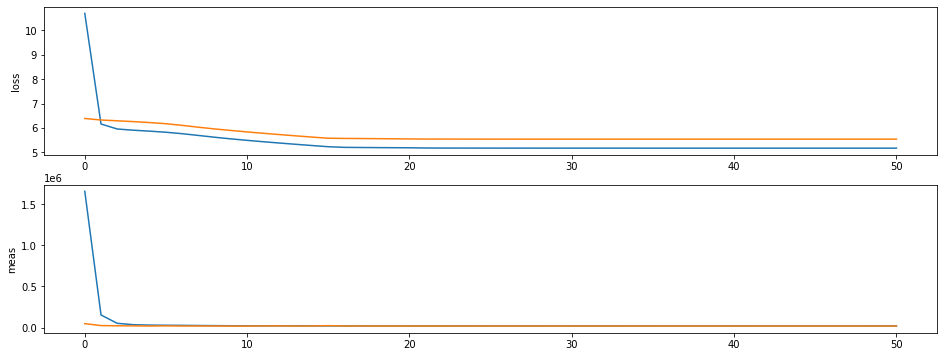

In [26]:

plt.figure(figsize = (16,6))
plt.subplot(2,1,1)
plt.plot(history['train_loss'], label = 'train')
plt.plot(history['valid_loss'], label = 'valid')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(history['train_meas'], label = 'train')
plt.plot(history['valid_meas'], label = 'valid')
plt.ylabel('meas')

#  Output

In [27]:
# Load submission sample
submission = pd.read_csv(str(data_dir / "sample_submission.csv"))
print(submission.shape)
submission.head()

(91486, 4)


,phone,millisSinceGpsEpoch,latDeg,lngDeg
0,2020-05-15-US-MTV-1_Pixel4,1273608785432,37.904611,-86.481078
1,2020-05-15-US-MTV-1_Pixel4,1273608786432,37.904611,-86.481078
2,2020-05-15-US-MTV-1_Pixel4,1273608787432,37.904611,-86.481078
3,2020-05-15-US-MTV-1_Pixel4,1273608788432,37.904611,-86.481078
4,2020-05-15-US-MTV-1_Pixel4,1273608789432,37.904611,-86.481078


In [28]:
model.load_state_dict(torch.load(checkpoint_name))
torch.save(model.state_dict(), f"./models/{hyper_parameters['notebookName']}/model-{num_files}_checkpoint/model-{epoch}-{min_valid_meas}.pth")

In [29]:
predict = test(test_loader)
print(predict.shape)
predict.head()

  0%|          | 0/358 [00:00<?, ?it/s]

ValueError: Must have equal len keys and value when setting with an ndarray

In [41]:
submission = submission[['phone', 'millisSinceGpsEpoch']].merge(predict[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']]
                                                                , on = ['phone', 'millisSinceGpsEpoch'])
print(submission.shape)
submission.head()

(91486, 4)


,phone,millisSinceGpsEpoch,latDeg,lngDeg
0,2020-05-15-US-MTV-1_Pixel4,1273608785432,37.471195,-122.268791
1,2020-05-15-US-MTV-1_Pixel4,1273608786432,37.471199,-122.268791
2,2020-05-15-US-MTV-1_Pixel4,1273608787432,37.471195,-122.268791
3,2020-05-15-US-MTV-1_Pixel4,1273608788432,37.471195,-122.268791
4,2020-05-15-US-MTV-1_Pixel4,1273608789432,37.471195,-122.268791


In [42]:
submission.to_csv(f"./models/{hyper_parameters['notebookName']}/result-{num_files}esult.csv", index = False)
pd.DataFrame([]).to_csv(PATH / f"{num_files}")